## SimCLR ImageWang Tutorial

**Note:** This notebook demonstrates how to use `SimCLR` callback with a single GPU. For distributed version, `DistributedSimCLR` checkout documentation.

First import **fastai** for training and other helpers, you can choose not to use **wandb** by setting `WANDB=False`.

In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb

torch.backends.cudnn.benchmark = True
WANDB = False

Then import **self_supervised** `augmentations` module for creating augmentations pipeline, `layers` module for creating encoder and model, and finally `simclr` for self-supervised training.

In [2]:
from self_supervised.augmentations import *
from self_supervised.layers import *
# from self_supervised.vision.simclr import *

In this notebook we will take a look at [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) benchmark, how to train a self-supervised model using MoCo algorithm and then how to use this pretrained model for finetuning on the given downstream task. 

## Pretraining

In [3]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

ImageWang has several benchmarks for different image sizes, in this tutorial we will go for `size=224` and also demonstrate how effectively you can utilize GPU memory.

Define batch size, resize resolution before batching and size for random cropping during self-supervised training. It's always good to use a batch size as high as it can fit the GPU memory.

In [4]:
bs, resize, size = 256, 256, 224

Select architecture to train on, remember all **timm** and **fastai** models are available! We need to set `pretrained=False` here because using imagenet weights for ImageWang data would be cheating.

In [5]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [6]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Initialize the Dataloaders using the function above.

In [7]:
dls = get_dls(resize, bs)

Create SimCLR model. You can change values of `hidden_size`, `projection_size`, and `n_layers`. For this problem, defaults work just fine so we don't do any changes.

In [11]:
#export
class BarlowTwinsModel(Module):
    "An encoder followed by a projector" 
    def __init__(self,encoder,projector): self.encoder,self.projector = encoder,projector
    def forward(self,x): return self.projector(self.encoder(x))

In [12]:
#export
def create_barlow_twins_model(encoder, hidden_size=256, projection_size=128, nlayers=3):
    "Create SimCLR model"
    n_in  = in_channels(encoder)
    with torch.no_grad(): representation = encoder(torch.randn((2,n_in,128,128)))
    projector = create_mlp_module(representation.size(1), hidden_size, projection_size, bn=True, nlayers=3) 
    apply_init(projector)
    return BarlowTwinsModel(encoder, projector)

In [13]:
model = create_barlow_twins_model(encoder, hidden_size=768, projection_size=768)

In [14]:
model.projector

Sequential(
  (0): Linear(in_features=1024, out_features=768, bias=True)
  (1): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=768, out_features=768, bias=True)
)

Next step is perhaps the most critical step for achieving good results on a custom problem - data augmentation. For this, we will use utility function from `self_supervised.vision.simclr.get_simclr_aug_pipelines` but you can also use your own list of Pipeline augmentations. `self_supervised.vision.simclr.get_moco_aug_pipelines`should be enough for most of the cases since under the hood it uses `self_supervised.augmentations.get_multi_aug_pipelines` and `self_supervised.augmentations.get_batch_augs`. You can do shift+tab and see all the arguments that can be passed to `get_simclr_aug_pipelines`. You can simply pass anything that you could pass to `get_batch_augs` including custom `xtra_tfms`.

`get_simclr_aug_pipelines` excepts size for random resized cropping of the 2 views of a given image and the rest of the arguments are coming from `get_batch_augs()`

In [15]:
aug_pipelines = get_multi_aug_pipelines(n=2, size=size, rotate=True, 
                                        rotate_deg=10, jitter=True, bw=True, blur=False)

In [16]:
aug_pipelines

[Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)},
 Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0} -> Normalize -- {'mean': tensor([[[[0.4850]],
 
          [[0.4560]],
 
          [[0.4060]]]], device='cuda:0'), 'std': tensor([[[[0.2290]],
 
          [[0.2240]],
 
          [[0.2250]]]], device='cuda:0'), 'axes': (0, 2, 3)}]

Here, we will feed the augmentation pipelines and leave temperature parameter as default.

In [17]:
#export
class BarlowTwins(Callback):
    order,run_valid = 9,True
    def __init__(self, aug_pipelines, lmb=0.1, print_augs=False):
        assert_aug_pipelines(aug_pipelines)
        self.aug1, self.aug2 = aug_pipelines
        if print_augs: print(self.aug1), print(self.aug2)
        store_attr('lmb')
        
        
    def before_fit(self): 
        self.learn.loss_func = self.lf
        nf = self.learn.model.projector[-1].out_features
        self.I = torch.eye(nf).to(self.dls.device)
                    
            
    def before_batch(self):
        xi,xj = self.aug1(self.x), self.aug2(self.x)
        self.learn.xb = (torch.cat([xi, xj]),)
        
    
    def lf(self, pred, *yb):
        bs,nf = pred.size(0)//2,pred.size(1)
        z1, z2 = pred[:bs],pred[bs:]
        
        z1norm = (z1 - z1.mean(0)) / z1.std(0, unbiased=False)
        z2norm = (z2 - z2.mean(0)) / z2.std(0, unbiased=False)
        
        C = (z1norm.T @ z2norm) / bs 
        cdiff = (C - self.I)**2
        loss = (cdiff*self.I + cdiff*(1-self.I)*self.lmb).sum() 
        return loss

    
    @torch.no_grad()
    def show(self, n=1):
        bs = self.learn.x.size(0)//2
        x1,x2  = self.learn.x[:bs], self.learn.x[bs:] 
        idxs = np.random.choice(range(bs),n,False)
        x1 = self.aug1.decode(x1[idxs].to('cpu').clone()).clamp(0,1)
        x2 = self.aug2.decode(x2[idxs].to('cpu').clone()).clamp(0,1)
        images = []
        for i in range(n): images += [x1[i],x2[i]] 
        return show_batch(x1[0], None, images, max_n=len(images), nrows=n)

In [18]:
cbs=[BarlowTwins(aug_pipelines, lmb=0.1)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [19]:
learn = Learner(dls, model, cbs=cbs)

Before starting training let's check whether our augmentations makes sense or not. Since this step consumes GPU memory, once you are done with inspection, restart the notebook and skip this step. We can see that 2 views of the same image side by side and indeed augmentations look pretty good. Now, it's time restart the notebook and skip this step.

In [16]:
# b = dls.one_batch()
# learn._split(b)
# learn('before_batch')
# learn.sim_clr.show(n=5);

Use mixed precision with `to_fp16()` for more GPU memory, larger batch size and faster training . We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [20]:
learn.to_fp16();

In [21]:
# learn.lr_find()

Learning good representations via contrastive learning usually takes a lot of epochs. So here number epochs are set to 100. This might change depending on your data distribution and dataset size.

In [22]:
lr,wd,epochs=1e-2,1e-2,100

In [ ]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time


In [ ]:
if WANDB: wandb.finish()

In [12]:
save_name = f'simclr_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

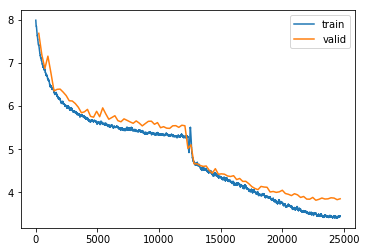

In [13]:
learn.recorder.plot_loss()

## Downstream Task

In [ ]:
optdict = dict(sqrmom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [ ]:
bs, size

In [ ]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [ ]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [ ]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [ ]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 20 epochs

In [ ]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 80 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/simclr_iwang_sz{size}_epc100_encoder.pth')]

In [ ]:
np.mean(acc)